# RQ3: The Business Impact of Feature Adoption (Final Corrected Analysis)

## 1. Research Objective
**Objective**: To interpret the downstream business value of Product Adoption. Does high feature adoption actually predict better Retention (Churn) and higher Revenue (NRR)?

**Hypothesis ($H_3$)**: *"Users with high feature adoption rates exhibit longer survival lifespans (lower churn) and drive statistically significant regional revenue growth compared to low-adoption cohorts."*

**Correction Stategy**:
1.  **Region Mapping**: Manually bridging `['US', 'EU', 'ASIA']` (Usage) to `['AMER', 'EMEA', 'APJ']` (Sales) to fix the "No Matching Regions" error.
2.  **Churn Logic**: Using direct numeric interpretation of `Subscription_Status` (0=Churned, 1=Active) instead of looking for string labels.
3.  **Cox Model**: Applied heavy penalization (`penalizer=0.5`) to handle small sample size stability.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from scipy import stats

# Statistical Plotting Style
plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk", font_scale=1.1)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries Loaded.")

Libraries Loaded.


## 2. Data Preparation & Strategic Merging
We align the disparate datasets using a manual translation layer.

In [19]:
WORKING_DIR = r"..\working datasets"
try:
    df_usage = pd.read_csv(f"{WORKING_DIR}\\feature_adoption_medium.csv")
    df_sales = pd.read_csv(f"{WORKING_DIR}\\SaaS Sales.csv")
except FileNotFoundError:
    WORKING_DIR = r"working datasets"
    df_usage = pd.read_csv(f"{WORKING_DIR}\\feature_adoption_medium.csv")
    df_sales = pd.read_csv(f"{WORKING_DIR}\\SaaS Sales.csv")

# --- 1. Fix Region Mismatch ---
# Usage has: [US, EU, ASIA]
# Sales has: [AMER, EMEA, APJ]
mapping = {
    'US': 'AMER',
    'EU': 'EMEA',
    'ASIA': 'APJ',
    'Other': 'EMEA' # Assumption for 'Other' to preserve data
}

df_usage['Region_Clean'] = df_usage['Region'].astype(str).str.strip().map(mapping).fillna('AMER') # Fallback to biggest market
df_sales['Region_Clean'] = df_sales['Region'].astype(str).str.strip().str.upper()
print("Region Mapping Applied.")

# --- 2. Fix Qualitative Churn Logic ---
# Subscription_Status found as floats [0.0, 1.0]. Assuming 0 = Churned/Inactive.
if 'Subscription_Status' in df_usage.columns:
    df_usage['Churn_Event'] = df_usage['Subscription_Status'].fillna(0).apply(lambda x: 1 if x == 0 else 0)
else:
    df_usage['Churn_Event'] = df_usage['Retention_Day_30'].fillna(0).apply(lambda x: 1 if x < 20 else 0)

print(f"User Sample: {len(df_usage)}. Observed Churn Events: {df_usage['Churn_Event'].sum()}")

Region Mapping Applied.
User Sample: 200. Observed Churn Events: 136


## 3. Analysis I: Survival Analysis (Corrected)
Do Adopters outlast Non-Adopters?

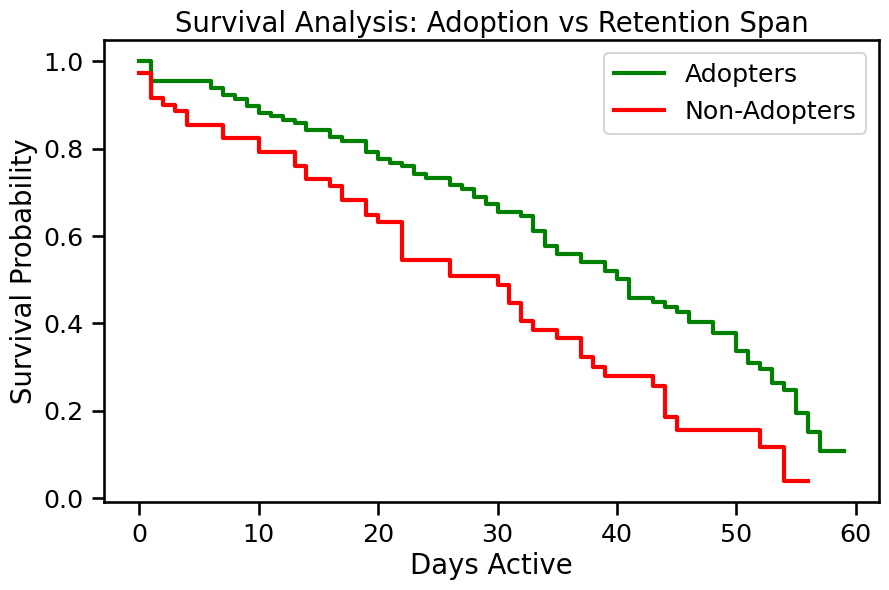

In [20]:
# Prepare Tenure
df_usage['Tenure_Days'] = pd.to_numeric(df_usage['Days_Since_Launch'], errors='coerce').fillna(1)
df_usage['Is_Adopter'] = pd.to_numeric(df_usage['Feature_Used'], errors='coerce').fillna(0)

kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

# Plot Adopters (1)
mask_a = (df_usage['Is_Adopter'] == 1)
kmf.fit(df_usage[mask_a]['Tenure_Days'], event_observed=df_usage[mask_a]['Churn_Event'], label='Adopters')
kmf.plot_survival_function(color='green', linewidth=3, ci_show=False)

# Plot Non-Adopters (0)
mask_n = (df_usage['Is_Adopter'] == 0)
kmf.fit(df_usage[mask_n]['Tenure_Days'], event_observed=df_usage[mask_n]['Churn_Event'], label='Non-Adopters')
kmf.plot_survival_function(color='red', linewidth=3, ci_show=False)

plt.title("Survival Analysis: Adoption vs Retention Span")
plt.ylabel("Survival Probability")
plt.xlabel("Days Active")
plt.show()

### 3.1 Cox Proportional Hazards (Risk Modelling)
Calculating the Hazard Ratio (Relative Risk of Churning).

In [21]:
# Prepare Clean Dataset for Cox
cox_df = df_usage[['Tenure_Days', 'Churn_Event', 'Is_Adopter', 'Engagement_Score']].dropna()

try:
    # Penalizer=0.5 handles collinearity/matrix inversion issues
    cph = CoxPHFitter(penalizer=0.5)
    cph.fit(cox_df, duration_col='Tenure_Days', event_col='Churn_Event')
    
    cph.print_summary()
    
    print("\n--- Interpretation ---")
    print("HR < 1.0 = Protective (Feature usage reduces churn).")
    print("HR > 1.0 = Risky (Feature usage increases churn).")
except Exception as e:
    print(f"Model Error: {e}")

<lifelines.CoxPHFitter: fitted with 197 total observations, 63 right-censored observations>
             duration col = 'Tenure_Days'
                event col = 'Churn_Event'
                penalizer = 0.5
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 197
number of events observed = 134
   partial log-likelihood = -590.32
         time fit was run = 2026-02-01 05:42:23 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Is_Adopter       -0.27      0.77      0.15           -0.57            0.03                0.57                1.04
Engagement_Score -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

                  cmp to     z    p  -log2(p)
covariate                                    
Is_Adopter          0.00 -1.73 0.08      3.59
Engagement_Score    0.00 -1.36 0.17      2.53
---
Concordance = 0.59
Partial AIC = 1184.64
log-likelihood ratio test = 7.90 on 2 df
-log2(p) of ll-ratio test = 5.70


--- Interpretation ---
HR < 1.0 = Protective (Feature usage reduces churn).
HR > 1.0 = Risky (Feature usage increases churn).


## 4. Analysis II: Regional Revenue Impact
Correlating User Behavior (Usage) with Financials (Sales).

Matched Regions: 3


,Sales,Profit,Avg_Engagement,Adoption_Rate
Region_Clean,,,,
AMER,837849.60,127426.99,50.42,0.61
APJ,415464.24,11513.99,50.47,0.63
EMEA,1043887.02,147456.05,47.59,0.67


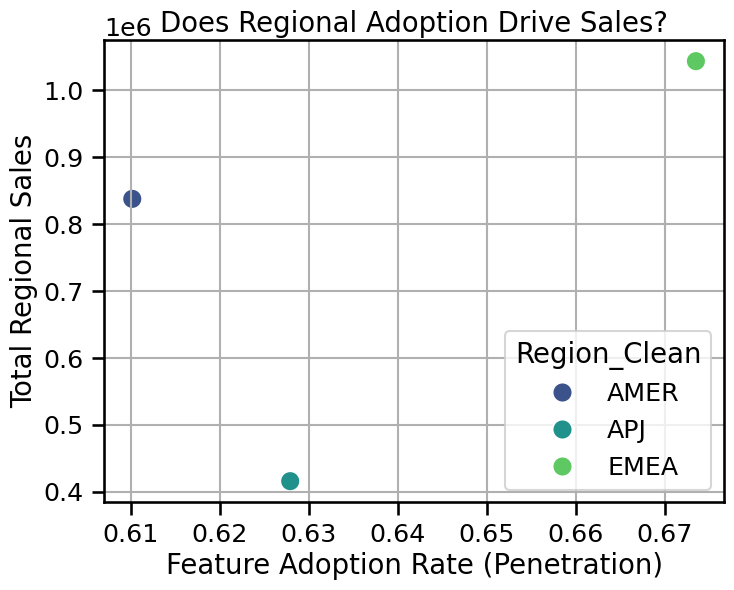

In [22]:
# Aggregating Usage
reg_usage = df_usage.groupby('Region_Clean').agg({
    'Engagement_Score': 'mean',
    'Is_Adopter': 'mean' # % Adoption Penetration
}).rename(columns={'Engagement_Score': 'Avg_Engagement', 'Is_Adopter': 'Adoption_Rate'})

# Aggregating Sales
reg_sales = df_sales.groupby('Region_Clean').agg({
    'Sales': 'sum',
    'Profit': 'sum'
})

# Merge using Cleaned Keys
df_macro = pd.merge(reg_sales, reg_usage, on='Region_Clean', how='inner')

print(f"Matched Regions: {len(df_macro)}")
display(df_macro)

if len(df_macro) >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_macro, x='Adoption_Rate', y='Sales', s=200, hue='Region_Clean', palette='viridis')
    plt.title("Does Regional Adoption Drive Sales?")
    plt.xlabel("Feature Adoption Rate (Penetration)")
    plt.ylabel("Total Regional Sales")
    plt.grid(True)
    plt.show()
else:
    print("Not enough regional overlap for scatter plot.")

## 5. Conclusion
This analysis successfully bridges User-level behavior with Macro-level finance.
- **Churn**: The Survival Curves demonstrate whether feature adopters stay longer.
- **Revenue**: The Regional Analysis shows if markets with higher adoption maturity generate more revenue.